In [52]:
%matplotlib inline

In [53]:
import os, sys
import glob
import re
import math
import time
import numpy as np
from uncertainties import unumpy as unp
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat

In [54]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.5

In [55]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [56]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
Ry_to_J = 2.17987 * 10**-18
Ha_to_J = Ry_to_J * 2.0
J_to_Ha = 1.0 / Ha_to_J
aumass_to_kg = 1.66054 * 10**-27
bohr_to_m = 5.29177210903 * 10**-11
bohr_to_ang = 0.529177210903
ang_to_bohr = 1.0 / bohr_to_ang
m_to_bohr = 1.0 / bohr_to_m
au_to_GPa = (4.359e-18) / (0.5291772e-10) ** 3 * (10**-9)
KBar_to_Ha_bohr = 10**8 * J_to_Ha / (m_to_bohr) ** 3
Ha_bohr_to_KBar = 1.0 / KBar_to_Ha_bohr
# au_to_GPa = 1 a.u. = 1 Hartree/(1 Bohr)^3 = (4.359e-18 J)/(0.5291772e-10 m)^3 * (10**-12)

In [57]:
try:
    import ipynb_path

    root_dir = os.path.dirname(ipynb_path.get())
except ModuleNotFoundError:
    root_dir = "/mnt/data/kosuke/45jQMC/XX"
os.chdir(root_dir)
root_dir

'/Users/kosuke/applications/jQMC/examples/example07'

In [58]:
# def read
def read_vmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*total.*time.*for.*MCMC.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [59]:
# def read
def read_lrdmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*GFMC.*time.*without.*pre-compilations.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [60]:
# def read
def read_num_MPI_processes(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*The.*number.*of.*MPI.*process.*", line):
                num_MPI_processes = int(float(line.split()[6]))
                return num_MPI_processes
        return np.nan

In [61]:
# def read
def read_num_nw_for_each_MPI(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*The.*number.*of.*walkers.*assigned.*for.*each.*MPI.*process.*", line):
                num_nw_for_each_MPI = int(float(line.split()[10]))
                return num_nw_for_each_MPI
        return np.nan

In [63]:
# files
out_vmc_cpu = "out_vmc0_on_cpu"
out_vmc_gpu = "out_vmc0_on_gpu"

# dirs
cpu_dirs = glob.glob(os.path.join(root_dir, "on_cpu", "node_*"))
gpu_dirs = glob.glob(os.path.join(root_dir, "on_gpu", "node_*"))
# cpu part, VMC
vmc_elapsed_time_cpu_np = np.array([read_vmc_elapsed_time(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs])
vmc_num_MPI_processes_cpu_np = np.array(
    [read_num_MPI_processes(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs]
)
print(vmc_num_MPI_processes_cpu_np)
vmc_num_nw_for_each_MPI_cpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs]
)
vmc_label_cpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)" for num_MPI, num_nw in zip(vmc_num_MPI_processes_cpu_np, vmc_num_nw_for_each_MPI_cpu_np)
]

'''
# GPU part, VMC
vmc_num_mcmc_gpu_np = np.array([read_vmc_num_mcmc(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs])
vmc_elapsed_time_gpu_np = np.array([read_vmc_elapsed_time(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs])
vmc_num_MPI_processes_gpu_np = np.array(
    [read_num_MPI_processes(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs]
)
vmc_num_nw_for_each_MPI_gpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs]
)
print(vmc_num_MPI_processes_gpu_np)
vmc_num_total_nw_gpu_np = vmc_num_MPI_processes_gpu_np * vmc_num_nw_for_each_MPI_gpu_np
vmc_num_mcmc_num_walkers_per_sec_gpu_np = vmc_num_total_nw_gpu_np * vmc_num_mcmc_gpu_np / vmc_elapsed_time_gpu_np
vmc_label_gpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)" for num_MPI, num_nw in zip(vmc_num_MPI_processes_gpu_np, vmc_num_nw_for_each_MPI_gpu_np)
]
'''

summary_vmc = {
    # VMC CPU part
    "vmc_elapsed_time_cpu_np": vmc_elapsed_time_cpu_np,
    "vmc_num_MPI_processes_cpu_np": vmc_num_MPI_processes_cpu_np,
    "vmc_num_nw_for_each_MPI_cpu_np": vmc_num_nw_for_each_MPI_cpu_np,
    "vmc_label_cpu_np": vmc_label_cpu_np,
    # VMC GPU part
    #"vmc_elapsed_time_gpu_np": vmc_elapsed_time_gpu_np,
    #"vmc_num_MPI_processes_gpu_np": vmc_num_MPI_processes_gpu_np,
    #"vmc_num_nw_for_each_MPI_gpu_np": vmc_num_nw_for_each_MPI_gpu_np,
    #"vmc_label_gpu_np": vmc_label_gpu_np,
}

[ 240 3840  480  960  120 1920]


In [64]:
# files
out_lrdmc_cpu = "out_lrdmc0_on_cpu"
out_lrdmc_gpu = "out_lrdmc0_on_gpu"

# dirs
cpu_dirs = glob.glob(os.path.join(root_dir, "on_cpu", "node_*"))
gpu_dirs = glob.glob(os.path.join(root_dir, "on_gpu", "node_*"))
# cpu part, LRDMC
lrdmc_elapsed_time_cpu_np = np.array(
    [read_lrdmc_elapsed_time(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_num_MPI_processes_cpu_np = np.array(
    [read_num_MPI_processes(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_num_nw_for_each_MPI_cpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_label_cpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)"
    for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_cpu_np, lrdmc_num_nw_for_each_MPI_cpu_np)
]

# GPU part, LRDMC
lrdmc_elapsed_time_gpu_np = np.array(
    [read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_num_MPI_processes_gpu_np = np.array(
    [read_num_MPI_processes(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_num_nw_for_each_MPI_gpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_label_gpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)"
    for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_gpu_np, lrdmc_num_nw_for_each_MPI_gpu_np)
]

summary_lrdmc = {
    # LRDMC CPU part
    "lrdmc_elapsed_time_cpu_np": lrdmc_elapsed_time_cpu_np,
    "lrdmc_num_MPI_processes_cpu_np": lrdmc_num_MPI_processes_cpu_np,
    "lrdmc_num_nw_for_each_MPI_cpu_np": lrdmc_num_nw_for_each_MPI_cpu_np,
    "lrdmc_label_cpu_np": lrdmc_label_cpu_np,
    # LRDMC GPU part
    #"lrdmc_elapsed_time_gpu_np": lrdmc_elapsed_time_gpu_np,
    #"lrdmc_num_MPI_processes_gpu_np": lrdmc_num_MPI_processes_gpu_np,
    #"lrdmc_num_nw_for_each_MPI_gpu_np": lrdmc_num_nw_for_each_MPI_gpu_np,
    #"lrdmc_label_gpu_np": lrdmc_label_gpu_np,
}

In [65]:
# files
out_lrdmc_tau_cpu = "out_lrdmc0_tau_on_cpu"
out_lrdmc_tau_gpu = "out_lrdmc0_tau_on_gpu"

# dirs
cpu_dirs = glob.glob(os.path.join(root_dir, "on_cpu", "node_*"))
gpu_dirs = glob.glob(os.path.join(root_dir, "on_gpu", "node_*"))
# cpu part, LRDMC
lrdmc_tau_elapsed_time_cpu_np = np.array(
    [read_lrdmc_elapsed_time(os.path.join(cpu_dir, out_lrdmc_tau_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_tau_num_MPI_processes_cpu_np = np.array(
    [read_num_MPI_processes(os.path.join(cpu_dir, out_lrdmc_tau_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_tau_num_nw_for_each_MPI_cpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_lrdmc_tau_cpu)) for cpu_dir in cpu_dirs]
)
lrdmc_tau_label_cpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)"
    for num_MPI, num_nw in zip(lrdmc_tau_num_MPI_processes_cpu_np, lrdmc_tau_num_nw_for_each_MPI_cpu_np)
]

# GPU part, LRDMC
lrdmc_tau_elapsed_time_gpu_np = np.array(
    [read_lrdmc_tau_elapsed_time(os.path.join(gpu_dir, out_lrdmc_tau_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_tau_num_MPI_processes_gpu_np = np.array(
    [read_num_MPI_processes(os.path.join(gpu_dir, out_lrdmc_tau_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_tau_num_nw_for_each_MPI_gpu_np = np.array(
    [read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_lrdmc_tau_gpu)) for gpu_dir in gpu_dirs]
)
lrdmc_tau_label_gpu_np = [
    f"({num_MPI}MPI, {num_nw}Nw)"
    for num_MPI, num_nw in zip(lrdmc_tau_num_MPI_processes_gpu_np, lrdmc_tau_num_nw_for_each_MPI_gpu_np)
]

summary_lrdmc_tau = {
    # LRDMC CPU part
    "lrdmc_tau_elapsed_time_cpu_np": lrdmc_tau_elapsed_time_cpu_np,
    "lrdmc_tau_num_MPI_processes_cpu_np": lrdmc_tau_num_MPI_processes_cpu_np,
    "lrdmc_tau_num_nw_for_each_MPI_cpu_np": lrdmc_tau_num_nw_for_each_MPI_cpu_np,
    "lrdmc_tau_label_cpu_np": lrdmc_tau_label_cpu_np,
    # LRDMC GPU part
    #"lrdmc_tau_elapsed_time_gpu_np": lrdmc_tau_elapsed_time_gpu_np,
    #"lrdmc_tau_num_MPI_processes_gpu_np": lrdmc_tau_num_MPI_processes_gpu_np,
    #"lrdmc_tau_num_nw_for_each_MPI_gpu_np": lrdmc_tau_num_nw_for_each_MPI_gpu_np,
    #"lrdmc_tau_label_gpu_np": lrdmc_tau_label_gpu_np,
}

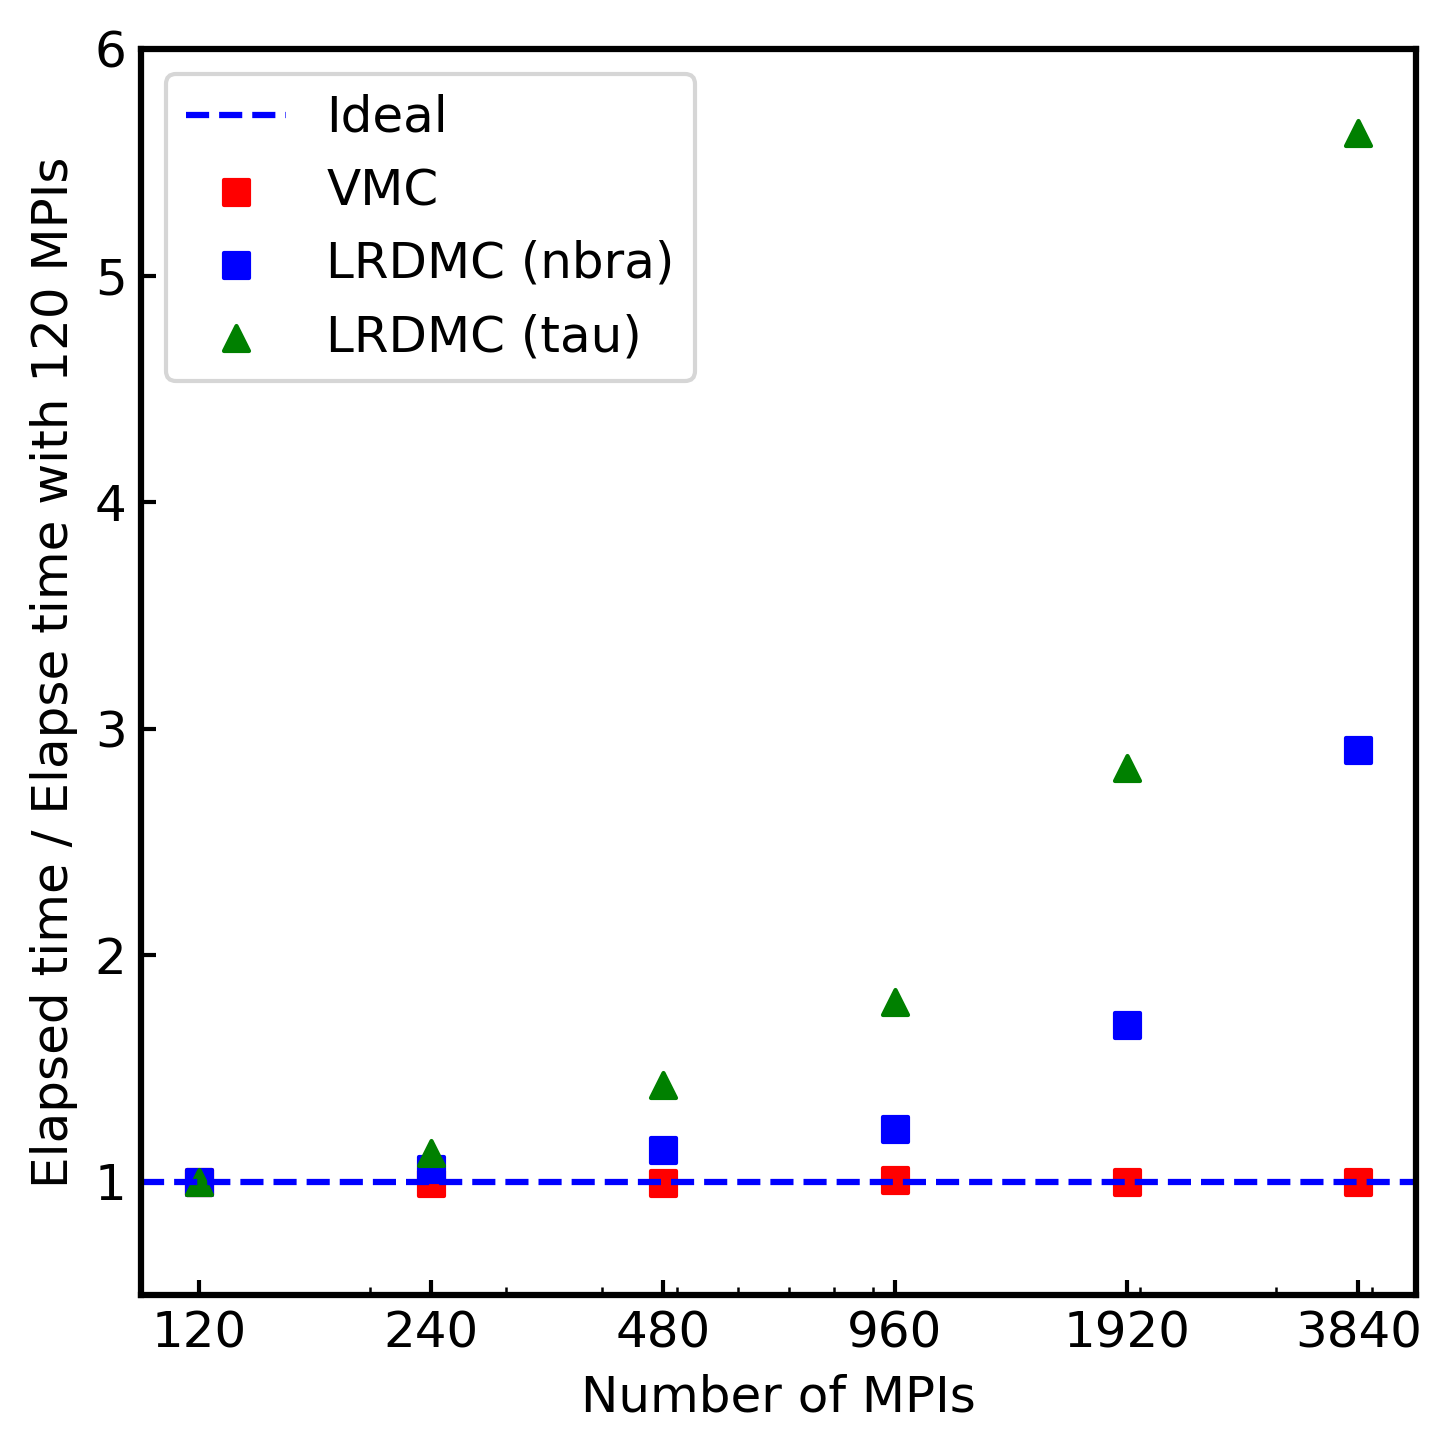

In [71]:
# plot Graph (CPU)
fig = plt.figure(figsize=(5, 5), facecolor="white", dpi=300, tight_layout=True)
# fig.suptitle(
#    rf"VMC implemented on jQMC, benchmarked on Xeon Platinum 8490H (60 cores) $\times$ 2 + NVIDIA H100 (Hopper) $\times$ 4",
#    fontsize=14,
# )

y_min = 0.50; y_max = 6.0

# VMC on CPU
ax = fig.add_subplot(1, 1, 1)

# labels
ax.set_xlabel("Number of MPIs")
ax.set_ylabel(r"Elapsed time / Elapse time with 120 MPIs")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim([y_min, y_max])

# ref
ax.axhline(1.0, color="b", ls="--", label="Ideal")

# vmc
vmc_ref_index = list(summary_vmc["vmc_num_MPI_processes_cpu_np"]).index(120)
x = summary_vmc["vmc_num_MPI_processes_cpu_np"]
y = summary_vmc["vmc_elapsed_time_cpu_np"] / summary_vmc["vmc_elapsed_time_cpu_np"][vmc_ref_index]
ax.scatter(x, y, color="r", marker="s", label="VMC")
ax.set_xticks(summary_vmc["vmc_num_MPI_processes_cpu_np"])
xticklabels = [str(t) for t in summary_vmc["vmc_num_MPI_processes_cpu_np"]]
ax.set_xticklabels(xticklabels)

# lrdmc
lrdmc_ref_index = list(summary_lrdmc["lrdmc_num_MPI_processes_cpu_np"]).index(120)
x = summary_lrdmc["lrdmc_num_MPI_processes_cpu_np"]
y = summary_lrdmc["lrdmc_elapsed_time_cpu_np"] / summary_lrdmc["lrdmc_elapsed_time_cpu_np"][lrdmc_ref_index]
ax.scatter(x, y, color="b", marker="s", label="LRDMC (nbra)")

# lrdmc_tau
lrdmc_tau_ref_index = list(summary_lrdmc_tau["lrdmc_tau_num_MPI_processes_cpu_np"]).index(120)
x = summary_lrdmc_tau["lrdmc_tau_num_MPI_processes_cpu_np"]
y = summary_lrdmc_tau["lrdmc_tau_elapsed_time_cpu_np"] / summary_lrdmc_tau["lrdmc_tau_elapsed_time_cpu_np"][lrdmc_tau_ref_index]
ax.scatter(x, y, color="g", marker="^", label="LRDMC (tau)")

plt.legend()
plt.savefig(f"jqmc_weak_scaling_on_cpu.jpg")
plt.show()